# Network analysis of patient flow

This notebook intend to use a **complex network** approach to **analyze the patient flow** through the municipalities in the Brazilian states. The first part of the analysis will be based on creating a network visualization, considering the centroids of municipalities as nodes, and the patient flow between them as edges. From this, we will apply some complex network techniques no analyze the hospitalization distribution into the studied Brazilian state. 

By analyzing the evolution of these data over the past 20 years for each Brazilian state, we can **evaluate the effectiveness of the regionalization process** in different regions of the country and in different moments of our recent history.

## Task Organization

1. Plot the patient flow network on the map   

2. Filter the flows to consider just relevant volume of patient displacements (> 10 patients, for example)

3. Improve the visualization: change the edge thickness according to the volume of the flow, for example
  
---

### Part 1: Plot the patient flow network on the map  
 - Using NetworkX 2.4 (https://networkx.github.io/)

In [1]:
# Import the patient flow data

import pandas as pd 

# read patient flow data for each Brazilian state and year, 1998 (0 - 2218506) and 2017 (2218507 - 4437013)
data = pd.read_csv("data/sih_mun_pairs_1998_2017.csv", usecols=['year', 'UF', 'CODMUN_ocor', 'CODMUN_res', 'nhospadm_total']) 

# filter data when there are any hospitalization (removing empty flows)
flow_data = data.dropna()

# filter the dataset to Bahia
is_BA = flow_data['UF']=='BA'
BA_flow_data = flow_data[is_BA]

year = int(input('Choose the dataset year (1998 or 2017): '))
if year < 2011: r_year = 2011
else: r_year = year

# filter the dataset only to one year
is_BA_year = BA_flow_data['year']==year
BA_flow_data_year = BA_flow_data[is_BA_year]

flows = BA_flow_data_year

Choose the dataset year (1998 or 2017): 2017


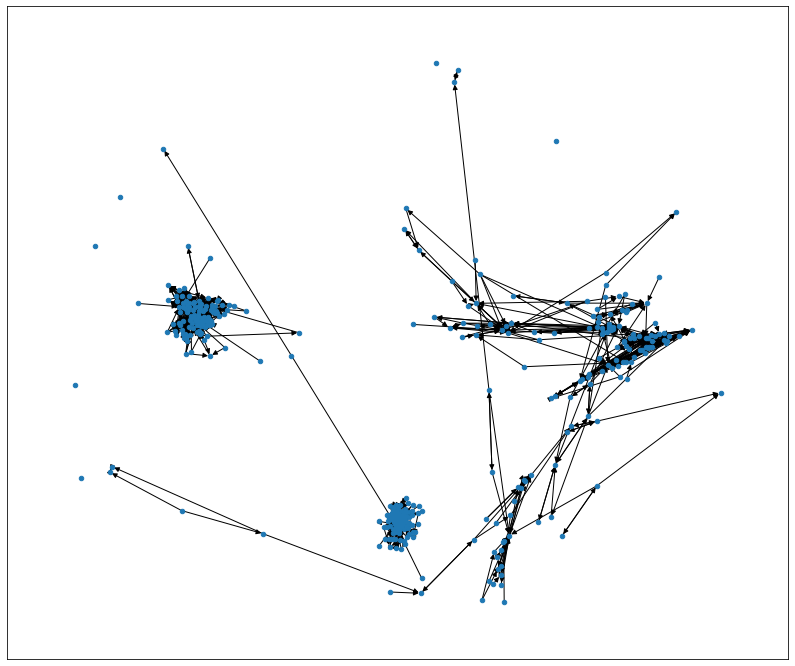

In [2]:
# plot the patient flow as a non spatial network

import networkx as nx
import matplotlib.pyplot as plt

graph = nx.from_pandas_edgelist(flows, source = 'CODMUN_res', target = 'CODMUN_ocor',
                        edge_attr = 'nhospadm_total',create_using = nx.DiGraph())
plt.figure(figsize=(14,12))
nx.draw_networkx(graph, pos=nx.spring_layout(graph, k=0.1, weight='nhospadm_total'), node_size=20, with_labels=False)
plt.show()

#### Import and save the IBGE municipalities data

source (using 2019*): https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais

*buscar a malha territorial para os outros anos (2000, 2005, 2010, 2015-2019), caso necessario

In [3]:
import geopandas as gpd
import numpy as np

municipalities_data = gpd.read_file("data/BA_Municipios_2019.dbf", encoding = "utf-8")
codes = np.array([item[:-1] for item in np.array(municipalities_data.CD_MUN)]).astype('int') # trim last char
centroids = municipalities_data.geometry.centroid

# municipalities [CODE, NAME, SHAPE, CENTROID_POINT]
municipalities = np.c_[codes, municipalities_data.NM_MUN, municipalities_data.geometry, centroids]

In [4]:
# fetch municipalities name and positions

M = nx.Graph()
M.name = {}
M.position = {}
for i in range(municipalities.shape[0]):
    M.name[municipalities[i][0]] = municipalities[i][1]
    M.position[municipalities[i][0]] = (municipalities[i][3].x, municipalities[i][3].y)

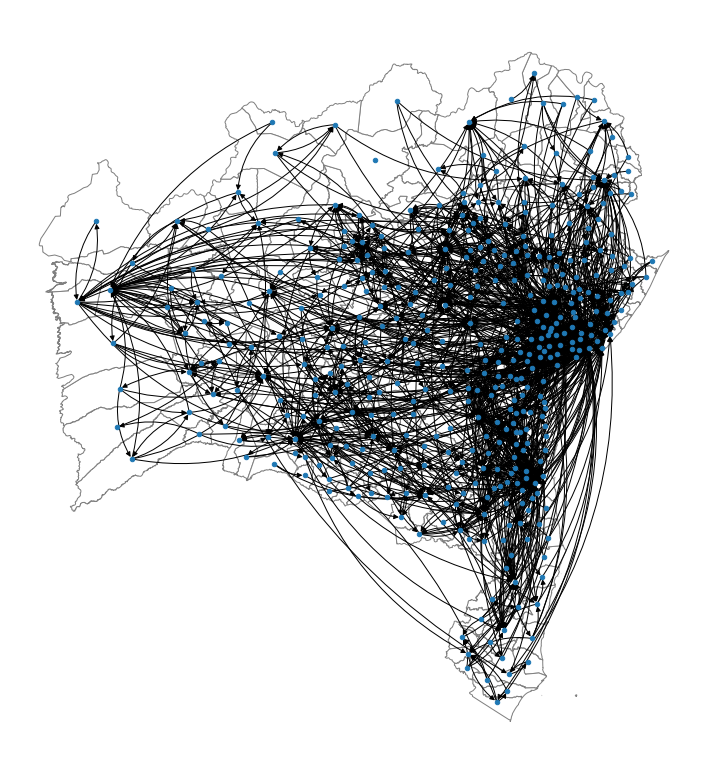

In [5]:
# plot the patient flow as a spatial network

fig, ax = plt.subplots(figsize=(18, 14))
gpd.GeoSeries(municipalities.T[2]).plot(ax=ax, color='white', edgecolor='gray')
nx.draw(graph, M.position, node_size=20, connectionstyle= 'arc3,rad=0.2', with_labels=False)

plt.show()

### Part 2: Filter the flows according to the volume of patient displacements

##### Getting the number of hospitalizations for each municipality 

In [6]:
# get the number of hospitalizations each municipality had

array_flows = np.array(flows).T[[2, 3, 4]].T.astype('int')
array_flows = array_flows[array_flows[:,0].argsort()]
hosp_per_mun = np.zeros((np.unique(array_flows.T[0]).shape[0], 2), dtype='int')
curr_code = array_flows[0][0]
i = 0

for flow in array_flows:
    if flow[0] != curr_code:
        curr_code = flow[0]
        i += 1
    hosp_per_mun[i][0] = flow[0]
    hosp_per_mun[i][1] += flow[2]

In [7]:
M.hospitalization = {}
for i in range(hosp_per_mun.shape[0]):
    M.hospitalization[hosp_per_mun[i][0]] = hosp_per_mun[i][1]

for i in range(municipalities.shape[0]):
    if not municipalities[i][0] in M.hospitalization:
        M.hospitalization[municipalities[i][0]] = 0

#### I. To show only the flows with more than **X%** of the patient displacements

In [8]:
# GET 0.01% OF TOTAL FLOWS

total_flows = flows['nhospadm_total'].sum()

X = 0.0001
part_flows = total_flows*X

gt_X = flows['nhospadm_total'] > part_flows
gt_X_flows = flows[gt_X]

print(gt_X_flows.shape[0], "flows, each one greater than", int(part_flows), "patients")

554 flows, each one greater than 70 patients


In [9]:
gt_X_graph = nx.from_pandas_edgelist(gt_X_flows, source = 'CODMUN_res', target = 'CODMUN_ocor',
                        edge_attr = 'nhospadm_total',create_using = nx.DiGraph())
fig, ax = plt.subplots(figsize=(18, 14))
gpd.GeoSeries(municipalities.T[2]).plot(ax=ax, color='white', edgecolor='gray')
nx.draw(gt_X_graph, M.position, node_size=20, connectionstyle= 'arc3,rad=0.2', with_labels=False)
plt.show()

#### II. (NOT USED) To show only the flows going to a municipality with more than **X%** of the patient displacements

In [10]:
# X = 0.01  # 1% of total flows
# part_flows = total_flows*X

# mt_X = hosp_per_mun.T[1] > part_flows
# mt_X_mun = hosp_per_mun[mt_X]

# is_mt_X = np.isin(flows['CODMUN_ocor'], mt_X_mun.T[0])
# mt_X_mun = flows[is_mt_X]

# print(mt_X_mun.shape[0], "flows, each one going to a municipality that receives more than", int(part_flows), "hospitalizations")

# gt_X_graph = nx.from_pandas_edgelist(mt_X_mun, source = 'CODMUN_res', target = 'CODMUN_ocor',
#                         edge_attr = 'nhospadm_total',create_using = nx.DiGraph())
# fig, ax = plt.subplots(figsize=(10, 9))
# gpd.GeoSeries(municipalities.T[2]).plot(ax=ax, color='white', edgecolor='gray')
# nx.draw(gt_X_graph, G.position, node_size=20, with_labels=False)
# plt.show()

### Part 3: Improve the visualization
 - Change the edge thickness according to the volume of the flow
 - Change the edge color and opacity
 - Change the node size according to the volume of patients the municipality received

#### I. Static visualization

In [16]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 16))
fig.set_facecolor('whitesmoke')
gpd.GeoSeries(municipalities.T[2]).plot(ax=ax, color='lightgray', zorder=1)
gpd.read_file('data/BA_regions/BA_regions_%d.shp'%r_year).plot(ax=ax, facecolor='none', edgecolor='gray', zorder=2)

gt_X_graph = nx.from_pandas_edgelist(gt_X_flows, source = 'CODMUN_res', target = 'CODMUN_ocor',
                                     edge_attr = 'nhospadm_total', create_using = nx.DiGraph())

# nodes
all_nodes = gt_X_graph.nodes

nsmall = [node for node in all_nodes if M.hospitalization[node] < 5000]
nlarge = [node for node in all_nodes if M.hospitalization[node] >= 5000]

node_size_small = [M.hospitalization[code]*0.01 for code in nsmall]
node_size_large = [M.hospitalization[code]*0.01 for code in nlarge]

nx.draw_networkx_nodes(gt_X_graph, M.position, node_size=node_size_small, nodelist=nsmall,  node_color='w')
nx.draw_networkx_nodes(gt_X_graph, M.position, node_size=node_size_large, nodelist=nlarge,  node_color='gray')

# edges
all_edges = gt_X_flows.to_numpy().T[[2, 3, 4]].T

esmall = [(v, u) for (u, v, d) in all_edges if d < 100]
emedium = [(v, u) for (u, v, d) in all_edges if d >= 100 and d < 500]
elarge = [(v, u) for (u, v, d) in all_edges if d >= 500]

nx.draw_networkx_edges(gt_X_graph, M.position, edgelist=esmall, alpha=0.6, width=1, edge_color='teal', connectionstyle= 'arc3,rad=0.2')
nx.draw_networkx_edges(gt_X_graph, M.position, edgelist=emedium, alpha=0.6, width=4, edge_color='teal', connectionstyle= 'arc3,rad=0.2')
nx.draw_networkx_edges(gt_X_graph, M.position, edgelist=elarge, alpha=0.8, width=12, edge_color='teal', connectionstyle= 'arc3,rad=0.2')

edge_lines = [Line2D([0, 1], [0, 2], color='teal', alpha=0.8, lw=w) for w in [1, 4, 10]]
node_lines = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor=clr, ms=s, mec='gray') for s, clr in [(10, 'w'), (20, 'gray')]]
regions_line = [Line2D([0, 1], [0, 2], color='gray', alpha=0.8, lw=1)]

plt.legend(edge_lines+node_lines+regions_line, 
           ['< 100 patients displacement', '>= 100 and < 500 patients', '>= 500 patients', '< 5000 hospitalizations', '>= 5000 hospitalizations', 'Limits of Health Regions'], 
           loc=3, fontsize = 'x-large')

plt.title('Significant Patient Displacements (> '+str(int(part_flows))+' per link)\n in the state of Bahia, '+str(year), fontsize = 'x-large')
ax.axis("off")
plt.show()